# Captstone Project

In [719]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from warnings import filterwarnings
filterwarnings("ignore")

In [720]:
from re import sub

import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [721]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import pairwise_distances

In [722]:
import gzip
import pickle

## Dataset

In [723]:
df = pd.read_csv("sample30.csv")

In [724]:
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [725]:
df.shape

(30000, 15)

## Data Wrangling

### Missing Value Treatment

In [726]:
missing_values_pct = (df.isnull().sum())
missing_values_pct

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

#### Dropping Columns with More Than 50% Missing Values

In [727]:
drop_cols = ["reviews_userCity", "reviews_userProvince"]

In [728]:
df.drop(drop_cols, axis=1, inplace=True)

#### For Columns with Less Missing Values, we will drop the corresponding rows

In [729]:
df = df[~df['manufacturer'].isnull()]
df = df[~df['reviews_date'].isnull()]
df = df[~df['reviews_title'].isnull()]
df = df[~df['reviews_username'].isnull()]
df = df[~df['user_sentiment'].isnull()]

In [730]:
df["manufacturer"]

0        Universal Music Group / Cash Money
1                                  Lundberg
2                                  Lundberg
3                                       K-Y
4                                       K-Y
                        ...                
29995                         L'oreal Paris
29996                         L'oreal Paris
29997                         L'oreal Paris
29998                         L'oreal Paris
29999                         L'oreal Paris
Name: manufacturer, Length: 29566, dtype: object

### Checking The Missing Values Again

In [731]:
missing_values_pct = np.round(df.isnull().sum()/df.shape[0]*100,2)
missing_values_pct[missing_values_pct>0]

reviews_didPurchase    46.12
reviews_doRecommend     7.90
dtype: float64

We are not doing any missing value treatment for 'reviews_didPurchase' & 'reviews_doRecommend' as we will do some Exploratory Data Analysis

#### Extracting Month & Year from the Dates

In [732]:
def clean(text):
    return text.split("T")[0]

df["reviews_date"] = df["reviews_date"].apply(clean)

In [733]:
df["date"] = pd.to_datetime(df["reviews_date"], errors="coerce")

In [734]:
df[["reviews_date", "date"]]
df.loc[df["date"].isnull()]

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,date
28421,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,False,True,3,We moved into a home that already had this pot...,It matches what was already there.,hatestandinginlines,Positive,NaT
28422,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,False,True,5,Just bought one of these racks after first fin...,"Great little rack, amazing price",karenh2008,Positive,NaT
28423,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,False,True,5,Living in a townhome definitely has it's perks...,Perfect for my Townhome!,hellodanielle,Positive,NaT
28424,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,True,True,5,My daughter-in-law purchased this and I liked ...,Excellent Purchase,laurel,Positive,NaT
28425,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,True,True,5,Heavy duty - very durable-looking. Much more t...,great quality!,janet,Positive,NaT
28426,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,False,True,5,"I have a large kitchen, but over my stove wher...",ceiling pot rack,cookinmama2002,Positive,NaT
28427,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,False,True,5,These units are easy to assemble sturdy and of...,A Great Value,projectbound,Positive,NaT
28428,AVpfSFDo1cnluZ0-hwjT,Concept Housewares,"Kitchen & Dining,Kitchen Storage & Organizatio...",Group5 Mktg/Concept Housewares,Concept Housewares 36 Natural Wood ceiling mou...,hooks slide or swivel into any desired positi...,True,True,5,i love the pot rack. it was very easy to put t...,great product,chomie,Positive,NaT


In [735]:
df = df[~df['date'].isnull()]
df.drop("reviews_date", axis=1, inplace=True)
df["Month"] = df["date"].dt.month
df["Year"] = df["date"].dt.year

### Mapping the values in user_sentiment column to numeric values

In [736]:
df["user_sentiment"] = df["user_sentiment"].map({"Positive":1, "Negative":-1})

## Exploratory Data Analysis

In [737]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29558 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   29558 non-null  object        
 1   brand                29558 non-null  object        
 2   categories           29558 non-null  object        
 3   manufacturer         29558 non-null  object        
 4   name                 29558 non-null  object        
 5   reviews_didPurchase  15923 non-null  object        
 6   reviews_doRecommend  27222 non-null  object        
 7   reviews_rating       29558 non-null  int64         
 8   reviews_text         29558 non-null  object        
 9   reviews_title        29558 non-null  object        
 10  reviews_username     29558 non-null  object        
 11  user_sentiment       29558 non-null  int64         
 12  date                 29558 non-null  datetime64[ns]
 13  Month                29558 non-

### Checking Class Imbalance

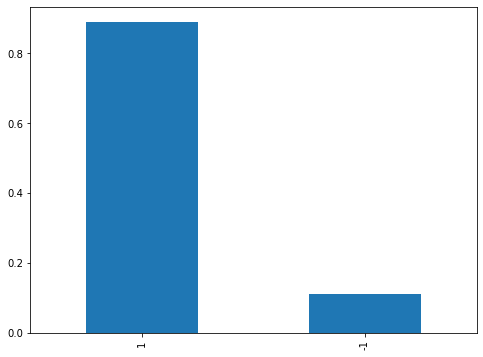

In [738]:
plt.figure(figsize=(8,6))
df["user_sentiment"].value_counts(normalize=True).plot.bar()
plt.show()

We see that there is a very huge class imbalance in the favour of positive reviews. We will deal with that later.

### Purchased Products

In [739]:
purchased = df.loc[df["reviews_didPurchase"]==True]

#### Top 10 Purchased Brands

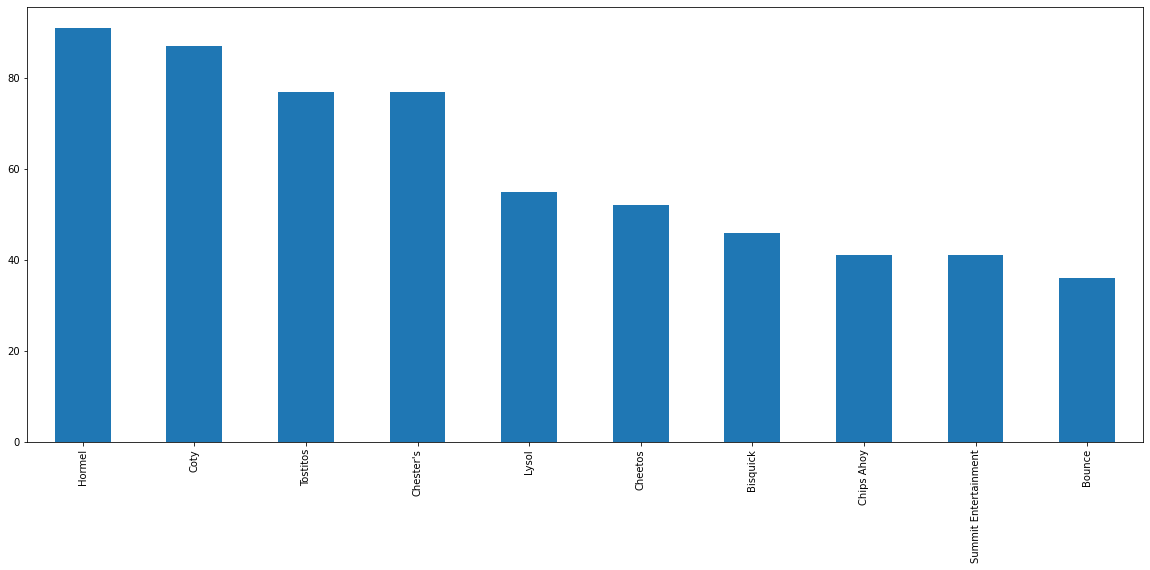

In [740]:
plt.figure(figsize=(20,8))
purchased["brand"].value_counts().head(10).plot.bar()
plt.show()

#### Top 10 Manufacturers whose products were purchased

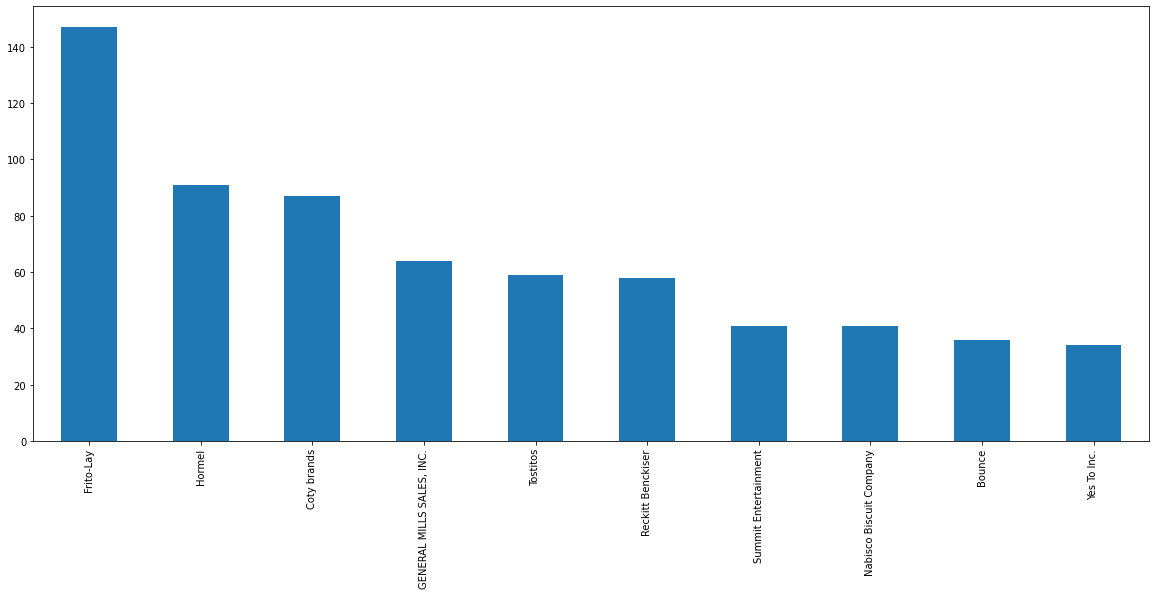

In [741]:
plt.figure(figsize=(20,8))
purchased["manufacturer"].value_counts().head(10).plot.bar()
plt.show()

#### Top 10 Purchased Products

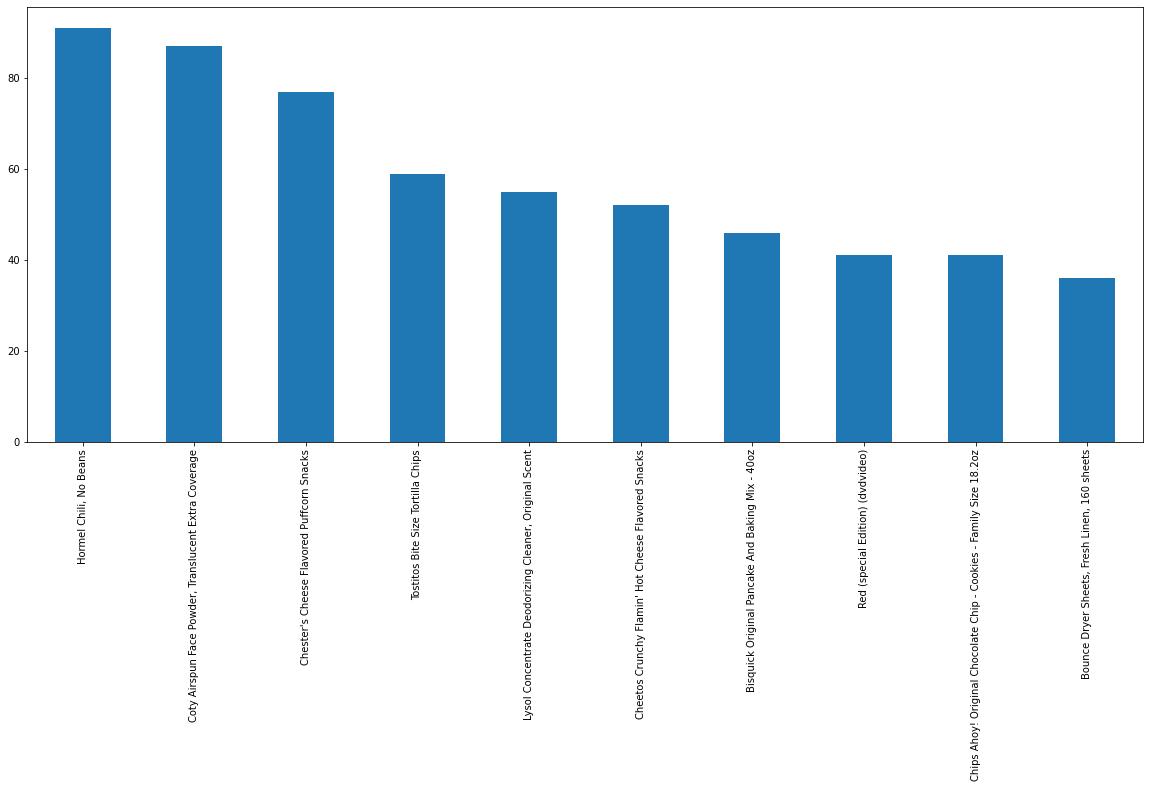

In [742]:
plt.figure(figsize=(20,8))
purchased["name"].value_counts().head(10).plot.bar()
plt.show()

#### Purchased Products By Year

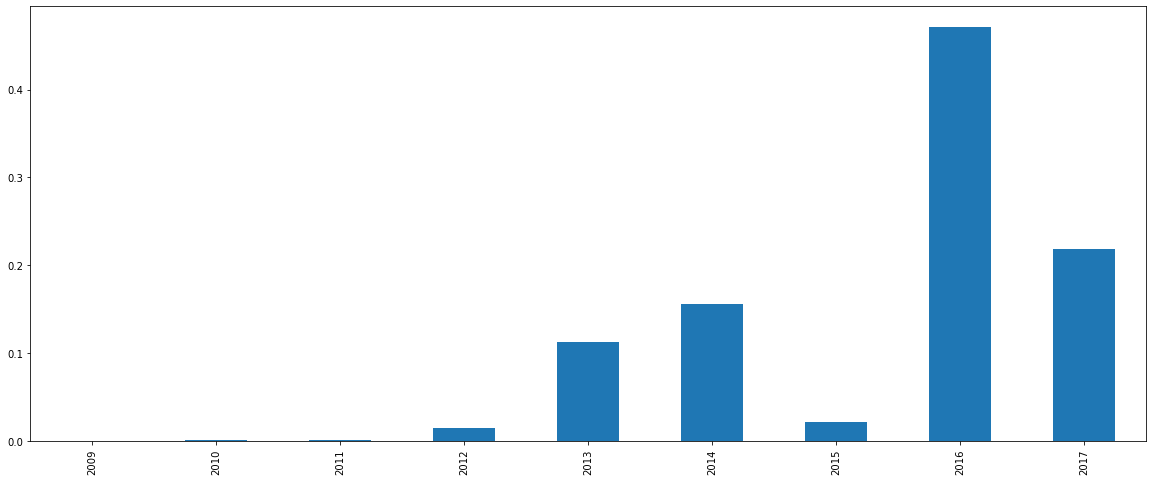

In [743]:
plt.figure(figsize=(20,8))
purchased["Year"].astype("int64").value_counts(normalize=True).sort_index().plot.bar()
plt.show()

#### Purchased Products By Month

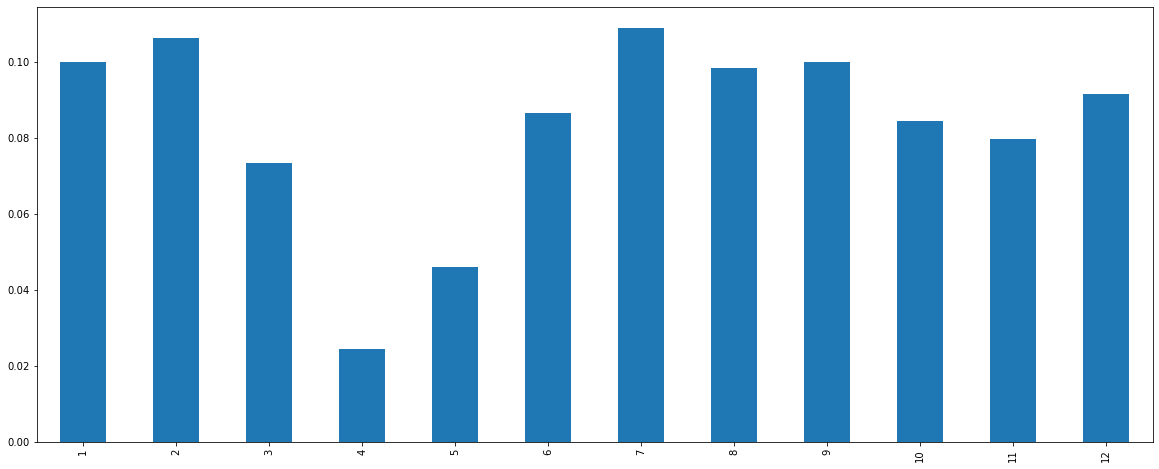

In [744]:
plt.figure(figsize=(20,8))
purchased["Month"].astype("int64").value_counts(normalize=True).sort_index().plot.bar()
plt.show()

### Recommended Products

In [745]:
recommended = df.loc[df["reviews_doRecommend"]==True]

#### Top 10 Recommended Brands

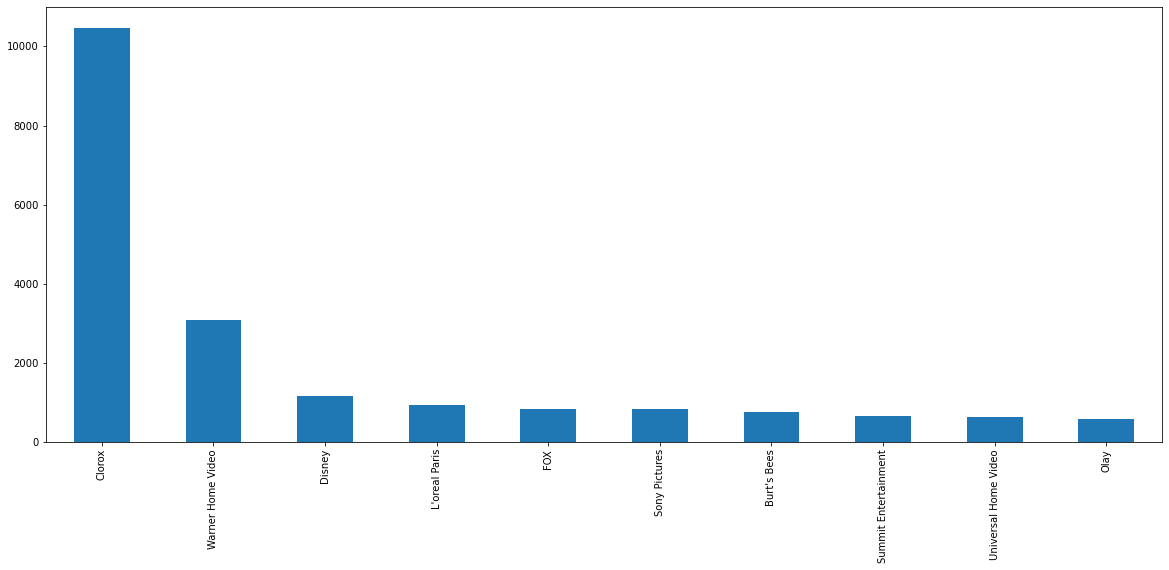

In [746]:
plt.figure(figsize=(20,8))
recommended["brand"].value_counts().head(10).plot.bar()
plt.show()

#### Top 10 Manufacturers whose products were recommended

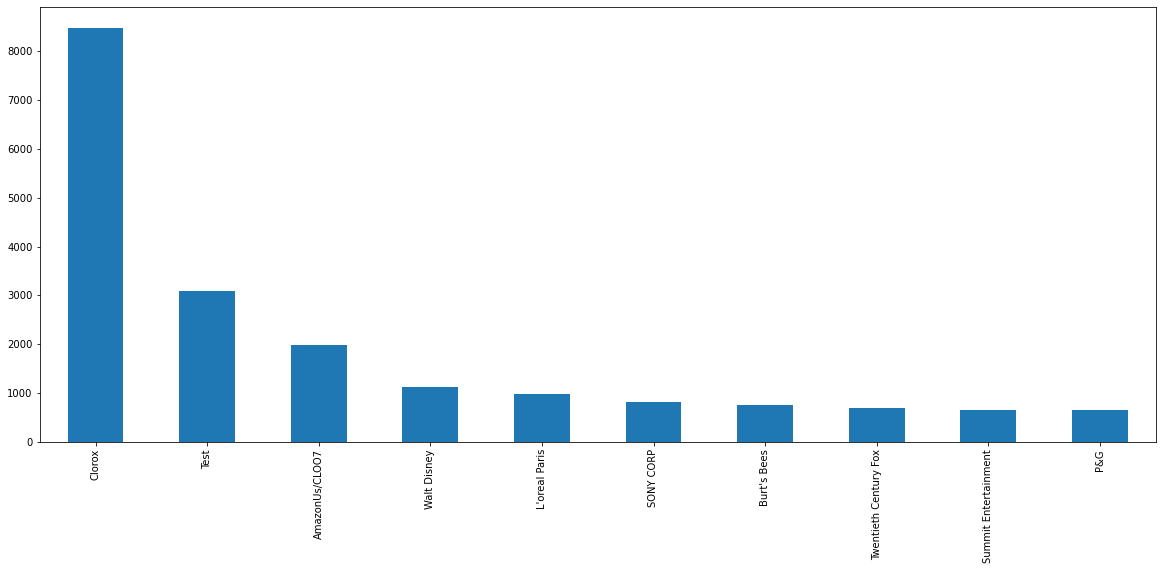

In [747]:
plt.figure(figsize=(20,8))
recommended["manufacturer"].value_counts().head(10).plot.bar()
plt.show()

#### Top 10 Recommended Products

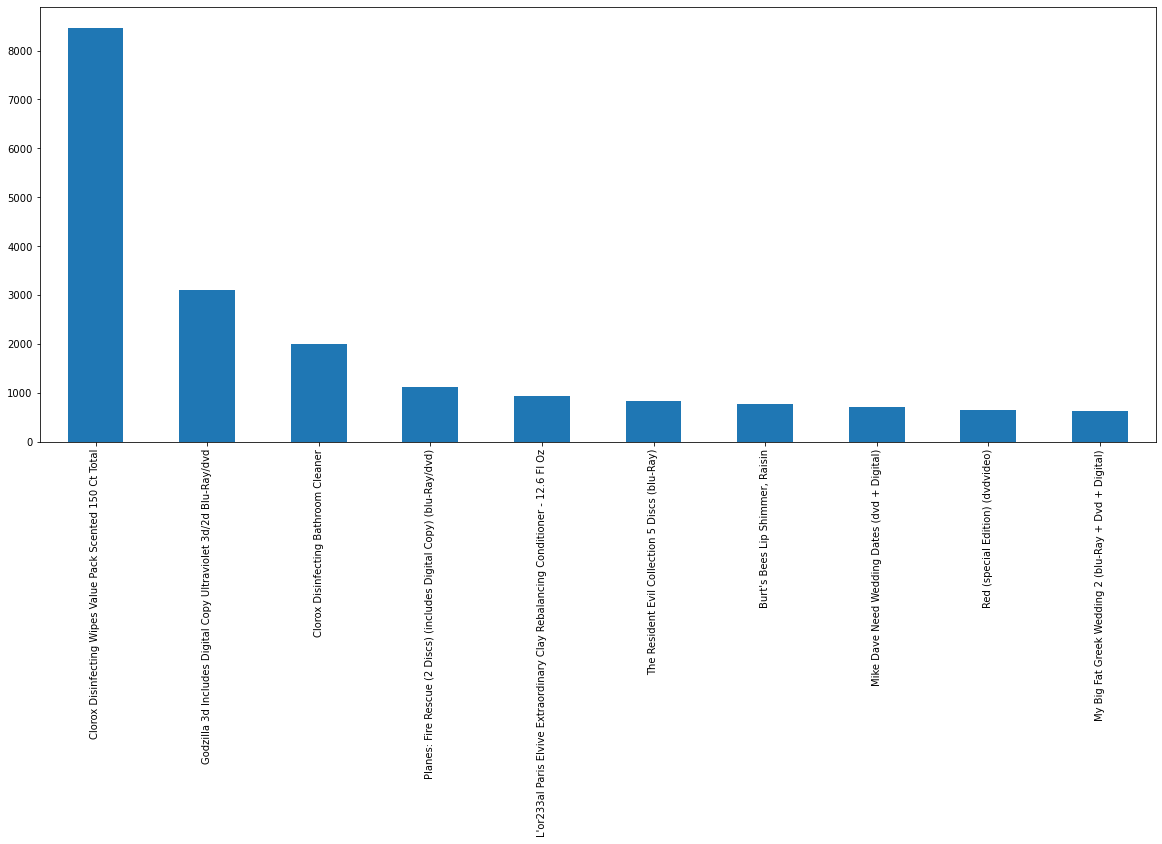

In [748]:
plt.figure(figsize=(20,8))
recommended["name"].value_counts().head(10).plot.bar()
plt.show()

## Model Building

### Text Preprocessing

#### Combining the "reviews_title" & "reviews_text" into a single feature

In [749]:
df["reviews"] = df[["reviews_title", "reviews_text"]].agg(" ".join, axis=1)

#### Cleaning the text

In [750]:
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stopwords]
    return " ".join(words)

In [751]:
def clean_text(text):
    
    text = text.lower()                               #make the text lowercase
    text = sub(r'[^\w\s]','',text)                    #remove punctuation
    text = sub(r'[a-zA-Z]*\d+[a-zA-Z]*', '', text)    #remove words containing numbers
    
    return text.strip()

In [752]:
def lemmatize_text(text):
    text = clean_text(text)
    doc = nlp(text)    
        
    return " ".join([token.lemma_ for token in doc])

In [753]:
df["reviews"] = df["reviews"].apply(remove_stopwords)

In [754]:
df["reviews"] = df["reviews"].apply(clean_text)

In [755]:
df["reviews"] = df["reviews"].apply(lemmatize_text)

#### Save the preprocessed data for future use

In [756]:
pickle.dump(df, open('pickle/processed_data.pkl', 'wb'))

#### Converting The Text To Features

In [757]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df["reviews"])

In [758]:
# Save vocabulary of TF-IDF to a pickle file
pickle.dump(tfidf.vocabulary_, open("pickle/tfidf_vocab.pkl","wb"))

In [759]:
y = df["user_sentiment"]

### Train Test Split

In [760]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Using SMOTE to deal with Class Imbalance

In [761]:
print("Before using SMOTE technique, value counts of the target variable")
print(y_train.value_counts())

smote = SMOTE(random_state = 2)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("\nAfter using SMOTE technique, value counts of the target variable")
print(y_train.value_counts())

Before using SMOTE technique, value counts of the target variable
 1    19659
-1     2509
Name: user_sentiment, dtype: int64

After using SMOTE technique, value counts of the target variable
-1    19659
 1    19659
Name: user_sentiment, dtype: int64


### Training The Models

In [762]:
def show_metrics(y_pred):
    plt.figure(figsize=(10,6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='.2f', cmap="Greens")
    plt.show()
    
    f1 = f1_score(y_test, y_pred)
    print("F1 score: {}".format(np.round(f1, 2)))

In [774]:
X_train.shape

(39318, 17240)

#### Logistic Regression

In [763]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

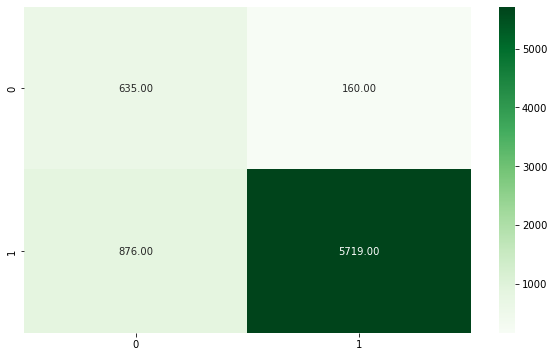

F1 score: 0.92


In [764]:
show_metrics(y_pred)

#### Random Forest

In [765]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

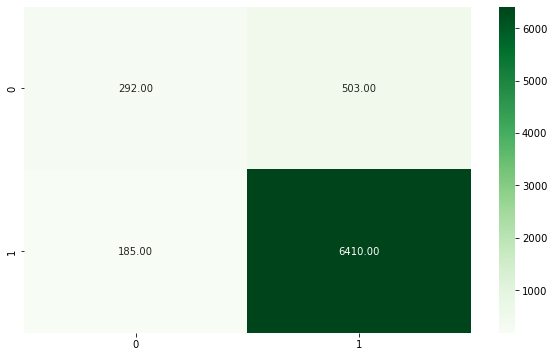

F1 score: 0.95


In [766]:
show_metrics(y_pred)

#### XGBoost

In [767]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

[18:27:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


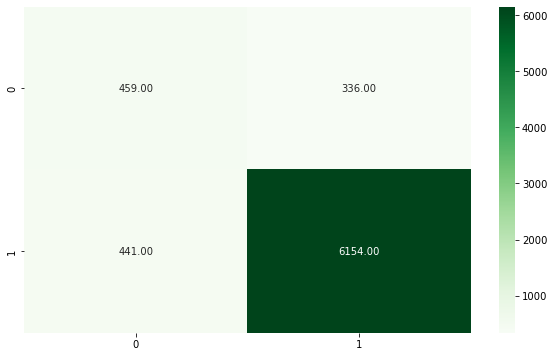

F1 score: 0.94


In [768]:
show_metrics(y_pred)

#### Naive Bayes

In [769]:
nbc = GaussianNB()
nbc.fit(X_train.toarray(), y_train)
y_pred = nbc.predict(X_test.toarray())

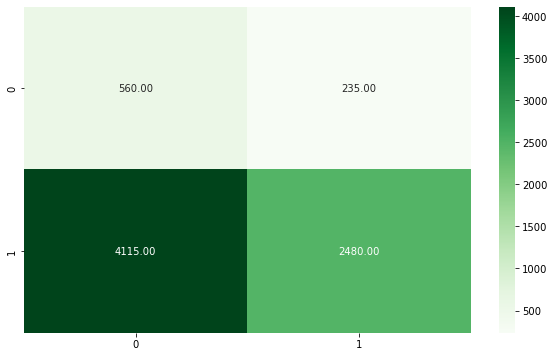

F1 score: 0.53


In [770]:
show_metrics(y_pred)

As we can see, the RandomForestClassifier model has the best F1 score. Going forward we will use that as our machine learning model.

Also the Random Forest Classifier has a F1 score of 0.95 which is very good. So we will not perform hyper-parameter tuning for this model

In [779]:
with gzip.open("pickle/rfc.pkl", 'wb') as f:
    pickle.dump(lr, f, -1)

## Recommendation Engine

In [674]:
# Reading The dataset
df = pd.read_csv("sample30.csv")

# Having a look at the dataset
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


### User Based Recommendation System

In [675]:
# Create a new dataframe 'ratings' containing only three useful columns from df
ratings = df[["reviews_username", "id", "reviews_rating"]]

# Rename columns for our convenience
ratings.columns = ['user', 'product', 'rating']

In [676]:
#Splitting the dataset into train and test
train, test = train_test_split(ratings, test_size=0.30, random_state=31)

In [677]:
# Create a pivot table with all user names as index, all products as columns and ratings as values
# Note: Here we use fillna(0) to give 0 ratings to products that have not been rated by corresponding user
df_pivot = train.pivot_table(
    index='user',
    columns='product',
    values='rating'
).fillna(0)

df_pivot.head()

product,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [678]:
# Copy the train dataset into dummy_train.
# It will be used later for prediction of the products that have not been rated by the user.
dummy_train = train.copy()

In [679]:
# The products not rated by user is marked as 1 for prediction.
# The products rated by user are ignored by marking them as 0.
dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x>=1 else 1)

In [680]:
dummy_train = dummy_train.pivot_table(
    index='user',
    columns='product',
    values='rating'
).fillna(1)

In [681]:
# Create a user-product matrix
df_pivot = train.pivot_table(
    index='user',
    columns='product',
    values='rating'
)

In [682]:
# Normalize the rating of the products for each user around 0 mean
# We do this by subtracting average ratings of users for a particular product from each user's rating
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()

product,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [683]:
# Create the user similarity Matrix using pairwise_distance function
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Prediction

In [684]:
# Replace negative correlations with 0
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [685]:
# Matrix multiplication of matrices user similarity matrix and original matrix df_pivot
# This will give predicted ratings of the users corresponding to each product in the dataset
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [686]:
# Multiplying 'dummy_train' with 'user_predicted_ratings' to make ratings of non-rated products 0
user_final_rating = np.multiply(user_predicted_ratings, dummy_train)
user_final_rating.head()

product,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Evaluation

In [687]:
# Extract users from test dataset that arepresent in the train dataset
common = test[test.user.isin(train.user)]

In [688]:
# convert into the user-movie matrix
common_user_based_matrix = common.pivot_table(index='user', columns='product', values='rating')
common_user_based_matrix.head()

product,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1ZSp2uglJLPUi8IQFy,AV1h6Gu0glJLPUi8IjA_,...,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrfHF1cnluZ0-pRai,AVpfshNsLJeJML43CB8q,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234asdf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [689]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18242,18243,18244,18245,18246,18247,18248,18249,18250,18251
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [690]:
# Set index of user correlation df as index of df_subtracted
user_correlation_df['user'] = df_subtracted.index
user_correlation_df.set_index('user',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18242,18243,18244,18245,18246,18247,18248,18249,18250,18251
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [691]:
# Put all user names in a list
list_name = common.user.tolist()

# Set column names of user correlation df as indices of df_subtracted
user_correlation_df.columns = df_subtracted.index.tolist()

# Filter out those user correlations that are present in both
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [692]:
# Filter out correlations of those users that are common in both train and test datasets
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

user_correlation_df_3 = user_correlation_df_2.T

user_correlation_df_3.head()

,00sab00,1234,1234asdf,123charlie,1943,4cloroxl,4djs,7inthenest,85lisa,a hutch,...,ygtz,yoadrian,yohnie1,yummy,yvonne,zach,zapman,zburt5,zebras,zmom
user,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234asdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [693]:
# Set negative correlations to 0
user_correlation_df_3[user_correlation_df_3<0]=0

# Dot product of 'user_correlation_df_3' and 'common_user_based_matrix'
common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [694]:
# We get the predicted ratings of users that have already rated the products
dummy_test = common.copy()

dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='user', columns='product', values='rating').fillna(0)

In [695]:
# Multiply 'common_user_predicted_ratings' with 'dummy_test'
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

# Check first few rows
common_user_predicted_ratings.head()

product,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1ZSp2uglJLPUi8IQFy,AV1h6Gu0glJLPUi8IjA_,...,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrfHF1cnluZ0-pRai,AVpfshNsLJeJML43CB8q,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234asdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [696]:
from numpy import *

# Create a copy of 'common_user_predicted_ratings'
X  = common_user_predicted_ratings.copy() 

# Filter out positive ratings
X = X[X>0]

# Normalize the ratings and bring them within range 1 to 5
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [697]:
# Find total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

314

In [698]:
# Calculate final RMSE value
rmse = (sum(sum((common_user_based_matrix - y )**2))/total_non_nan)**0.5
print(rmse)

2.4837351290124343


For User Based Recommendation System we have got a Root Mean Square Error (RMSE) of 2.48

### Item Based Recommendation System

In [699]:
# Create a pivot table with all user names as index, all products as columns and ratings as values
# Note: Here we take a transpose to get products (items) as indices and users as columns
df_pivot = train.pivot_table(
    index='user',
    columns='product',
    values='rating'
).T

df_pivot.head()

user,00dog3,00sab00,01impala,0325home,06stidriver,09mommy11,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,...,zozo0o,zpalma,zsazsa,zt313,zubb,zulaa118,zxcsdfd,zxjki,zyiah4,zzdiane
product,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [700]:
# We do normalization by subtracting average ratings of products for a particular user from each product's rating
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()  

user,00dog3,00sab00,01impala,0325home,06stidriver,09mommy11,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,...,zozo0o,zpalma,zsazsa,zt313,zubb,zulaa118,zxcsdfd,zxjki,zyiah4,zzdiane
product,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.103448,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [701]:
# Create the item similarity Matrix using pairwise_distance function
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [702]:
# Replace negative correlations with 0
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

#### Prediction

In [703]:
# This will give predicted ratings of the users corresponding to each product in the dataset
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0124448 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00053645, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00134112, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00713081, 0.        ,
        0.        ]])

In [704]:
# Multiplying 'dummy_train' with 'item_predicted_ratings' to make ratings of rated products 0
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

product,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,0.023523,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
00sab00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000573,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
01impala,0.0,0.0,0.012445,0.000000,0.0,0.0,0.0,0.0,0.000000,0.004599,...,0.007731,0.001157,0.075997,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
0325home,0.0,0.0,0.000000,0.001556,0.0,0.0,0.0,0.0,0.001952,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.001341,0.0,0.0
06stidriver,0.0,0.0,0.000000,0.001556,0.0,0.0,0.0,0.0,0.001952,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.001341,0.0,0.0


#### Evaluation

In [705]:
# Extract users from test dataset that are present in the train dataset
common = test[test['product'].isin(train['product'])]

In [706]:
common.head()

,user,product,rating
4332,sansname,AVpe9W4D1cnluZ0-avf0,5
3434,jennypstrong,AVpe5s3RLJeJML43x4eA,5
20634,girlie,AVpfkak01cnluZ0-nJj6,5
26479,kasheville,AVpfPPkEilAPnD_xX3cP,1
29726,payy,AVpfW8y_LJeJML437ySW,5


In [707]:
# convert into the item-product matrix (pivot form)
common_item_based_matrix = common.pivot_table(index='user', columns='product', values='rating').T
common_item_based_matrix.head()

user,00sab00,02dakota,02deuce,08dallas,1.11E+24,11677j,1234,1234asdf,123charlie,123rs,...,zokhid,zombiejess,zone,zoomin76,zoso60,zowie,zsarah,zuttle,zwithanx,zzz1127
product,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmDL9vKc47QAVgr7_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [708]:
# Convert the item_correlation matrix into dataframe.
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,242,243,244,245,246,247,248,249,250,251
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.038203,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.085762,0.0,0.0,0.0,0.0,0.0,0.0,0.001928,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [709]:
# Set index of item correlation df as index of df_subtracted
item_correlation_df['product'] = df_subtracted.index
item_correlation_df.set_index('product',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,242,243,244,245,246,247,248,249,250,251
product,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.038203,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.085762,0.0,0.0,0.0,0.0,0.0,0.0,0.001928,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [710]:
# Put all product names in a list
list_name = common['product'].tolist()

# Set column names of item correlation df as indices of df_subtracted
item_correlation_df.columns = df_subtracted.index.tolist()

# Filter out those item correlations that are present in both train and test datasets
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

item_correlation_df_3.head()

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
product,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.038203,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003657,0.0,...,0.085762,0.0,0.0,0.0,0.0,0.0,0.0,0.001928,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [711]:
# Set negative correlations to 0
item_correlation_df_3[item_correlation_df_3<0]=0

# Dot product of 'item_correlation_df_3' and 'common_item_based_matrix'
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.02074134, 0.01659307, ..., 0.        , 0.        ,
        0.        ],
       [0.01951687, 0.        , 0.        , ..., 0.        , 0.00155571,
        0.00124457],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00427849, 0.        , 0.        , ..., 0.        , 0.00134112,
        0.0010729 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [712]:
# We get the predicted ratings of products that have not been rated by the user
dummy_test = common.copy()

dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='user', columns='product', values='rating').T.fillna(0)

# Multiply 'common_item_predicted_ratings' with 'dummy_test'
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [713]:
common_item_predicted_ratings.head()

user,00sab00,02dakota,02deuce,08dallas,1.11E+24,11677j,1234,1234asdf,123charlie,123rs,...,zokhid,zombiejess,zone,zoomin76,zoso60,zowie,zsarah,zuttle,zwithanx,zzz1127
product,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [714]:
from numpy import *

# Create a copy of 'common_item_predicted_ratings'
X  = common_item_predicted_ratings.copy() 

# Filter out positive ratings
X = X[X>0]

# Normalize the ratings and bring them within range 1 to 5
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [715]:
# Find total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [716]:
# Calculate final RMSE value
rmse = (sum(sum((common_item_based_matrix - y )**2))/total_non_nan)**0.5
print(rmse)

3.5609275226619865


For Item Based Recommendation System we have got a Root Mean Square Error (RMSE) of 3.56

Thus we choose User Based Recommendation System as our recommendation system as it has less error

### Calculating Final Ratings With User Based Recommendation System

In [717]:
# Calculate final ratings
user_final_rating = np.multiply(user_predicted_ratings, dummy_train)
user_final_rating

product,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zulaa118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zxcsdfd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zxjki,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [718]:
# Saving the final ratings in a pickle file
pickle.dump(user_final_rating.astype('float32'), open('pickle/user_final_rating.pkl', 'wb'))